In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import math
from scipy.stats import bernoulli
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import linprog

In [36]:
def form_A_matrix(k):
    # Create a base matrix (identity matrix)
    identity_matrix = np.eye(k)

    # Create the negative counterpart
    negative_matrix = -np.eye(k)

    # Repeat identity matrix k times vertically and negative matrix k times horizontally
    repeated_identity = np.repeat(identity_matrix, k, axis=0)
    repeated_negative = np.tile(negative_matrix, (k, 1))

    # Combine the repeated matrices
    return repeated_identity + repeated_negative

In [37]:
def agent_oracle(s, incentive):
    return np.argmax(s+incentive)

In [38]:
class MoyenneEmpirique(object):

    def __init__(self, K, horizon,s, s_min, s_max):
        self.K = K
        self.recompenses = np.zeros(K)  # Reward
        self.tirages = np.zeros(K)      # Number of pulls
        self.t = 0                      # Time t
        self.horizon = 0

    def begin(self):
        self.recompenses.fill(0)
        self.tirages.fill(0)
        self.t = 0

    def choose(self):
        # 1st case: more arms to play
        if np.min(self.tirages) == 0:
            k = np.min(np.where(self.tirages == 0)[0])
        # 2nd case : all arms have been played
        else:
            moyennes_empiriques = self.recompenses / np.max(1, self.tirages)
            k = np.argmax(moyennes_empiriques)
        self.t += 1
        return k

    def reward(self, k, r):
        self.recompenses[k] += r
        self.tirages[k] += 1

In [39]:
class UCB(MoyenneEmpirique):

    def __init__(self, K, horizon):
        self.horizon = int(horizon)
        #assert alpha >= 0, "Erreur : alpha doit etre >= 0."
        self.alpha = 4   # UCB parameter, defined with respect to the rewards' subgaussianity
        self.K = K
        self.recompenses = np.zeros(self.K)
        self.t = 0
        self.tirages = np.zeros(self.K)

    def begin(self):
        self.recompenses.fill(0)
        self.tirages.fill(0)
        self.t = 0

    def choose(self):
        self.t += 1
        if np.min(self.tirages) == 0:
            k = np.min(np.where(self.tirages == 0)[0])
        else:
            moyennes_empiriques = self.recompenses / self.tirages
            ucb = np.sqrt(self.alpha * np.log(self.horizon) / self.tirages)
            indices = moyennes_empiriques + ucb
            k = np.argmax(indices)
        return k
    
    def reward(self, k, r):
        self.recompenses[k] += r
        self.tirages[k] += 1

In [40]:
class ipa(MoyenneEmpirique):

    def __init__(self, K, horizon, s_min, s_max):
        self.alpha = 4 # 4 for 1-subgaussian and horizon in the log
        self.horizon = int(horizon)
        self.K = K
        self.recompenses = np.zeros(K)  # Reward
        self.tirages = np.zeros(K)      # Number of pulls
        self.t = 0                      # Time t
        self.steps = 0
        self.incentive = np.zeros(K)
        self.s_min = s_min
        self.s_max = s_max
        self.estimates_low = np.zeros(K).astype(float)
        self.estimates_high = np.full(K,self.s_max-self.s_min).astype(float)

    def begin(self):
        self.recompenses.fill(0)
        self.tirages.fill(0)
        self.t = 0
        self.estimates_low = np.zeros(K)
        self.estimates_high = np.full(K,self.s_max-self.s_min).astype(float)

    def design(self, s):
        # 1st case : binary search
        self.incentive = np.zeros(self.K)
        if self.t < K*np.ceil(np.log(self.horizon)/np.log(2)):
            k = self.t%K
            mid = (self.estimates_low[k]+self.estimates_high[k])/2
            self.incentive[k] = mid
            self.t += 1
            if agent_oracle(s,self.incentive)==k:
                self.estimates_high[k] = mid
            else:
                self.estimates_low[k] = mid
            return self.incentive
        #2nd case: UCB subroutine
        if self.t == K*np.ceil(np.log(self.horizon)/np.log(2)):
            self.recompenses.fill(0)
            self.tirages.fill(0)
            k = 0
            self.incentive[k] = self.estimates_high[k] + 1/(self.horizon)**2
            self.t += 1
        if np.min(self.tirages) == 0:
            k = np.min(np.where(self.tirages == 0)[0])
            self.incentive[k] = self.estimates_high[k] + 1/(self.horizon)**2
            self.t += 1
        else:
            moyennes_empiriques = self.recompenses / self.tirages
            ucb = np.sqrt(self.alpha * np.log(self.horizon) / self.tirages)
            indices = moyennes_empiriques + ucb
            k = np.argmax(indices)
            self.incentive[k] = self.estimates_high[k] + 1/(self.horizon)**2
            self.t += 1
        return self.incentive

    def reward(self, k, r):
        self.recompenses[k] += r
        self.tirages[k] += 1

In [41]:
class epsilon_greedy(MoyenneEmpirique):

    def __init__(self, K, horizon, s_min, s_max):
        self.alpha = 1
        self.m = 500
        self.epsilon = 0
        self.beta = 0
        self.horizon = int(horizon)
        self.K = K
        self.recompenses = np.zeros(K)  # Reward
        self.tirages = np.zeros(K)      # Number of pulls
        self.t = 0                      # Time t
        self.steps = 0
        self.eta = 0
        self.incentive = np.zeros(self.K)
        self.s_min = s_min
        self.s_max = s_max
        self.A = self.form_A_matrix(self.K)
        # Contains rhs for inequalities of type s_a - s_b <= B(a,b)
        self.B_delta_s = np.ones((self.K, self.K)) * 1e8

        self.indice_list = []
        self.incentive_list = []

    def begin(self):
        self.recompenses.fill(0)
        self.tirages.fill(0)
        self.t = 0
        self.eta = 0
        self.beta = 0
        self.epsilon = 0
        self.estimates_low = np.zeros(K)
        self.estimates_high = np.full(K,self.s_max-self.s_min).astype(float)
        self.indice_list = []
        self.incentive_list = []
        self.incentive = np.zeros(self.K)
        self.explore = True

    def form_A_matrix(self, k):
        # Create a base matrix (identity matrix)
        identity_matrix = np.eye(k)
        negative_matrix = -np.eye(k)
        repeated_identity = np.repeat(identity_matrix, k, axis=0)
        repeated_negative = np.tile(negative_matrix, (k, 1))

        return repeated_identity + repeated_negative

    def loss(self, s):
        for tau in range(self.t):
            icv = self.incentive_list[tau]
            chosen_arm = self.indice_list[tau]
            for a in range(self.K):
                if (np.array(s)+np.array(icv))[a] > (np.array(s)+np.array(icv))[chosen_arm]:
                    return 10**4
        return 0

    def update_lin_system(self, incentive, k):
        self.B_delta_s[:, k] = np.minimum(self.B_delta_s[:, k], incentive[k] - incentive)

    def compute_incentive(self):
        cost = np.zeros((self.K))
        result = linprog(
            c = cost,
            A_ub = self.A,
            b_ub = self.B_delta_s.reshape(-1),
            bounds= np.array([(self.s_min, self.s_max) for _ in range(self.K)])
        )
        return result.x

    def design(self, s):
        # 1st case : one round per arm
        self.incentive = np.zeros(self.K)
        if self.t < self.K:
            k = self.t
            self.incentive[k] = self.s_max
            self.incentive_list.append(self.incentive)
            self.indice_list.append(agent_oracle(s, self.incentive))
            self.t += 1
        else:
            self.epsilon = min(1, self.m/(self.t))
            x = bernoulli.rvs(self.epsilon, size=1)[0]
            if x==1:
                self.explore = True
                self.incentive = np.random.uniform(self.s_min,self.s_max, self.K)
                self.eta += 1
            else:
                self.explore = False
                self.beta = np.sqrt(np.log(max(self.eta-1, 1))/(self.alpha*max(1, self.eta - 1)))
                estimate_incentive = self.compute_incentive()
                value = []
                for j in range(self.K):
                    moyennes_empiriques = self.recompenses / self.tirages

                    value.append(moyennes_empiriques[j] - np.max(estimate_incentive) + estimate_incentive[j] + 2 * self.beta)
                    k = np.argmax(value)
                    self.incentive = np.zeros(self.K)
                    self.incentive[k] = np.max(estimate_incentive) - estimate_incentive[k] + 2* self.beta
            self.t += 1
            self.incentive_list.append(self.incentive)
            self.indice_list.append(agent_oracle(s, self.incentive))
        return self.incentive

    def reward(self, k, r):
        if self.explore:
            self.update_lin_system(self.incentive, k)
        self.recompenses[k] += r
        self.tirages[k] += 1

In [42]:
true_reward = np.array([0.30, 0.24, 0.88, 0.07, 0.65])
s_vector = np.array([0.64, 0.99, 0.73, 0.61, 0.59])
test_reward = np.array([-0.05,  0.24,  0.62, -0.31,  0.25])  #test_reward = true_reward + s_vector - np.array([0.99, 0.99, 0.99, 0.99, 0.99])

In [43]:
from tqdm.notebook import trange
 
def simulation(algorithm, steps, s_vector):
    choice, reward, reward_cum = np.zeros(steps), np.zeros(steps), 0
    algorithm.begin()  #we initialize the algorithm

    for i in trange(steps):
        incentive = algorithm.design(s_vector)
        choice_i = agent_oracle(s_vector, incentive)

        reward_i = np.random.normal(true_reward[choice_i], 1) - incentive[choice_i]
        reward_cum += reward_i
        algorithm.reward(choice_i, reward_i)
        choice[i], reward[i] = choice_i, reward_cum/(i+1)

    return reward

def simulation_regret_UCB(algorithm, steps, K, true_reward):
    choice, reward, reward_cum, regret = np.zeros(steps), np.zeros(steps), 0, np.zeros(steps)
    algorithm.begin()  #we initialize the algorithm

    for i in trange(steps):
        choice_i = algorithm.choose()

        reward_i = np.random.normal(true_reward[choice_i], theta_var)
        reward_cum += reward_i

        regret_i = np.max(true_reward) - true_reward[choice_i]
        if i >=1:
            regret[i] = regret[i-1] + regret_i
        algorithm.reward(choice_i, reward_i)  #we update the reward given to the arm in the algorithm
        choice[i], reward[i] = choice_i, reward_cum/(i+1)
    return regret

def simulation_regret(algorithm, steps, K, s_vector, true_reward, theta_var):
    choice, reward, reward_cum, regret = np.zeros(steps), np.zeros(steps), 0, np.zeros(steps)
    algorithm.begin()  #we initialize the algorithm

    for i in trange(steps):
        incentive = algorithm.design(s_vector)
        choice_i = agent_oracle(s_vector, incentive)

        reward_i = np.random.normal(true_reward[choice_i], theta_var) - incentive[choice_i]
        reward_cum += reward_i

        optimal_incentive = np.full(K,np.max(s_vector)).astype(float) - s_vector
        regret_i = np.max(true_reward - optimal_incentive) - (true_reward - optimal_incentive)[choice_i]
        if i >=1:
            regret[i] = regret[i-1] + regret_i
        algorithm.reward(choice_i, reward_i)  #we update the reward given to the arm in the algorithm
        choice[i], reward[i] = choice_i, reward_cum/(i+1)

    return regret

def simulation_many_episodes(algorithm, steps, episodes, K, s_min, s_max, theta_min, theta_max, theta_var):
    overall_regret = [] #np.zeros(steps)
    true_reward = np.array([0.30, 0.24, 0.88, 0.07, 0.65])
    print(true_reward)
    s_vector = np.array([0.64, 0.99, 0.73, 0.61, 0.59])
    for i in trange(episodes):
        algorithm.begin()
        overall_regret.append(simulation_regret(algorithm, steps, K, s_vector, true_reward, theta_var))
    #overall_regret = overall_regret/episodes
    return np.array(overall_regret).mean(axis=0), np.array(overall_regret).std(axis=0)

In [44]:
def simulation_regret_UCB(algorithm, horizon, K, ucb_reward, theta_var):
    choice, reward, reward_cum, regret = np.zeros(horizon), np.zeros(horizon), 0, np.zeros(horizon)
    algorithm.begin() 
    for i in trange(horizon):
        choice_i = algorithm.choose()
        reward_i = np.random.normal(ucb_reward[choice_i], theta_var)
        reward_cum += reward_i
        regret_i = np.max(ucb_reward) - ucb_reward[choice_i]
        if i >=1:
            regret[i] = regret[i-1] + regret_i
        algorithm.reward(choice_i, reward_i)  #we update the reward given to the arm in the algorithm
        choice[i], reward[i] = choice_i, reward_cum/(i+1)
    return regret
def simulation_many_episodes_UCB(algorithm, horizon, episodes, K, theta_var):
    overall_regret = []
    ucb_reward = np.array([-0.05,  0.24,  0.62, -0.31,  0.25])
    for i in range(episodes):
        algorithm.begin()
        overall_regret.append(simulation_regret_UCB(algorithm, horizon, K, ucb_reward, theta_var))
    return np.array(overall_regret).mean(axis = 0), np.array(overall_regret).std(axis = 0)

In [45]:
horizon, episodes, K = 10000,30, 5   #horizon, episodes, number of arms
s_min, s_max = 0,1
theta_min, theta_max, theta_var = 0, 1, 1

mean_ipa_simulation, std_ipa_simulation = simulation_many_episodes(ipa(K, horizon, s_min, s_max), horizon, episodes, K, s_min, s_max, theta_min, theta_max, theta_var)
mean_eps_greedy_simulation, std_eps_greedy_simulation = simulation_many_episodes(epsilon_greedy(K, horizon, s_min, s_max), horizon, episodes, K, s_min, s_max, theta_min, theta_max, theta_var)
mean_ucb_simulation, std_ucb_simulation = simulation_many_episodes_UCB(UCB(K, horizon), horizon, episodes, K, theta_var)

[0.3  0.24 0.88 0.07 0.65]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[0.3  0.24 0.88 0.07 0.65]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

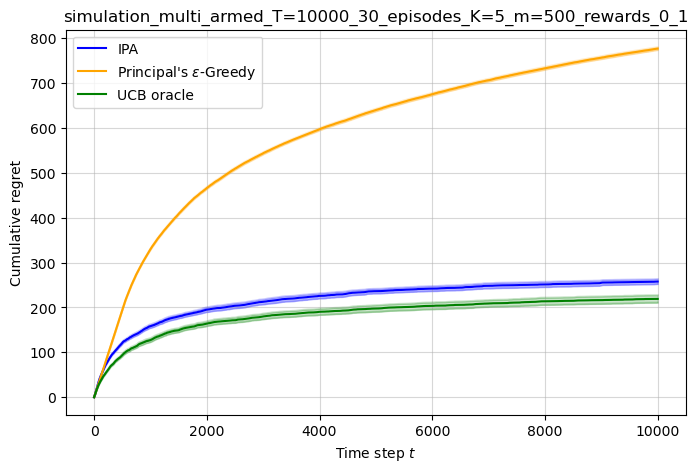

In [46]:
plt.figure(figsize=(8,5))
color_ipa = 'blue'
color_eps_greedy = 'orange'
color_ucb = 'green'
plt.plot(mean_ipa_simulation, label="IPA", color = color_ipa)
plt.plot(mean_ipa_simulation - std_ipa_simulation/(episodes**0.5), color=color_ipa, alpha=0.2)
plt.plot(mean_ipa_simulation + std_ipa_simulation/(episodes**0.5), color=color_ipa, alpha=0.2)
plt.fill_between(
    range(len(mean_ipa_simulation)),
    mean_ipa_simulation - std_ipa_simulation/(episodes**0.5),
    mean_ipa_simulation + std_ipa_simulation/(episodes**0.5),
    color=color_ipa,
    alpha=0.2,
)
plt.plot(mean_eps_greedy_simulation, label="Principal's $\epsilon$-Greedy", color = color_eps_greedy)
plt.plot(mean_eps_greedy_simulation - std_eps_greedy_simulation/(episodes**0.5), color = color_eps_greedy, alpha = 0.2)
plt.plot(mean_eps_greedy_simulation + std_eps_greedy_simulation/(episodes**0.5), color = color_eps_greedy, alpha = 0.2)
plt.fill_between(
    range(len(mean_eps_greedy_simulation)),
    mean_eps_greedy_simulation - std_eps_greedy_simulation/(episodes**0.5),
    mean_eps_greedy_simulation + std_eps_greedy_simulation/(episodes**0.5),
    color=color_eps_greedy,
    alpha=0.2,
)
plt.plot(mean_ucb_simulation, label="UCB oracle", color = color_ucb)
plt.plot(mean_ucb_simulation - std_ucb_simulation/(episodes**0.5), color = color_ucb, alpha = 0.2)
plt.plot(mean_ucb_simulation + std_ucb_simulation/(episodes**0.5), color = color_ucb, alpha = 0.2)
plt.fill_between(
    range(len(mean_ucb_simulation)),
    mean_ucb_simulation - std_ucb_simulation/(episodes**0.5),
    mean_ucb_simulation + std_ucb_simulation/(episodes**0.5),
    color=color_ucb,
    alpha=0.2,
)
plt.xlabel('Time step $t$', fontsize=10)
plt.ylabel('Cumulative regret', fontsize=10)
plt.title('simulation_multi_armed_T=10000_30_episodes_K=5_m=500_rewards_0_1')
plt.grid(alpha=0.5)
plt.legend()
plt.savefig('simulation_multi_armed_T=10000_30_episodes_K=500_m=500_rewards_0_1_std.pdf')